In [10]:
%reset -f
import sys
sys.path.insert(0, "..")
from wavhandler import *
from configs import DatasetConfiguration
from utils_train import *
from configs import *
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, make_scorer, log_loss
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import os
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Flatten
import seaborn as sb
import deepdish as dd
import seaborn as sns

seed = 42
np.random.seed(seed=seed)


data_setting = 'stftflt'

splitting = 'custom'
if data_setting.startswith('raw'):
    model_setting = 'conv1d'
else:
    model_setting = 'DenseNet121'

### data collecting

In [11]:
train = pd.read_csv(f"{TEMP_DATADIR}/df_train_{splitting}.csv", index_col=False)
X_train = train.x.tolist()
y_train = train.y.tolist()

val = pd.read_csv(f"{TEMP_DATADIR}/df_val_{splitting}.csv", index_col=False)
X_val = val.x.tolist()
y_val = val.y.tolist()

test = pd.read_csv(f"{TEMP_DATADIR}/df_test_{splitting}.csv", index_col=False)
X_test = test.x.tolist()
y_test = test.y.tolist()

print(f"train: \n{pd.Series(y_train).value_counts()}\n")
print(f"val: \n{pd.Series(y_val).value_counts()}\n")
print(f"test: \n{pd.Series(y_test).value_counts()}")

train: 
1    12357
2     4029
0     2958
dtype: int64

val: 
1    4144
2    1350
0     954
dtype: int64

test: 
1    12323
2     1745
0     1518
dtype: int64


## Loading model

############ INPUT SHAPE:(129, 120, 1)
0.90


(array([0.5, 1.5, 2.5]), <a list of 3 Text yticklabel objects>)

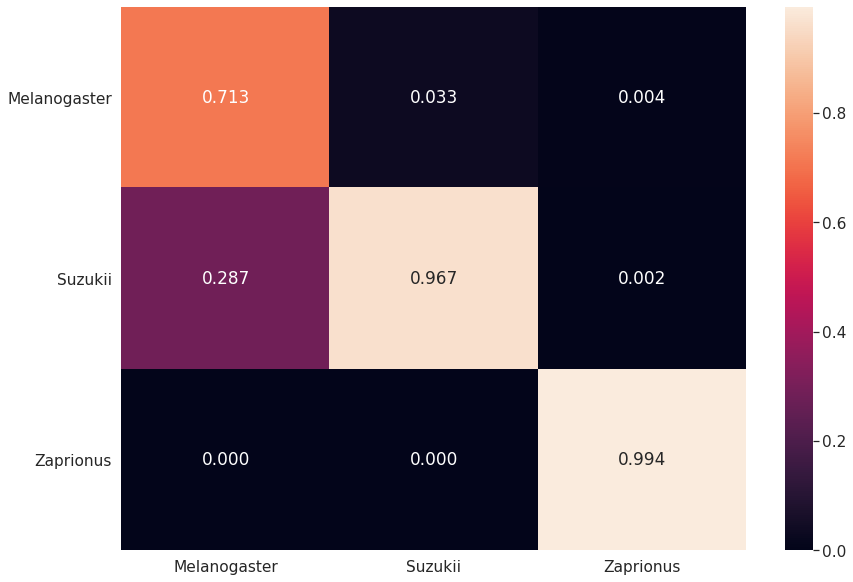

In [15]:
TL = False

if TL:
    data = Dataset('Wingbeats')
    print(data.target_classes)

    dataset = data
    splitting='random'
    modelname = f'{TEMP_DATADIR}/Flies_TL_{data_setting}_{model_setting}_{splitting}.h5'

    flag = ''
    traincf = TrainConfiguration(nb_classes=6, setting=data_setting, model_name=f'MosquitoNET_{data_setting}_{model_setting}_{splitting}_{flag}')
    using_conv2d = False
    base_model = ModelConfiguration(model_setting=model_setting, data_setting=data_setting, nb_classes=6).config
    base_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#     base_model.load_weights(traincf.top_weights_path)

    if data_setting == 'rawflt':
        model = Sequential()
        for layer in base_model.layers[:-1]: # go through until last layer
            model.add(layer)
        #     print(layer.trainable)
        model.add(Dense(3, activation='softmax'))
    elif data_setting == 'stftflt':
        base_output = base_model.layers[-2].output
        new_output = Dense(3, activation="softmax")(base_output)
        model = Model(inputs=base_model.inputs, outputs=new_output)
else:
    
    splitting = 'custom'
    modelname = f'{TEMP_DATADIR}/Flies_{data_setting}_{model_setting}_{splitting}.h5'
    
    traincf = TrainConfiguration(nb_classes=3, setting=data_setting, model_name=modelname)
    model = ModelConfiguration(model_setting=model_setting, data_setting=data_setting, nb_classes=3).config
model.load_weights(modelname)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

pred = model.predict(valid_generator(X_test, y_test,
                                     batch_size=traincf.batch_size,
                                     target_names=np.unique(y_test).tolist(),
                                     setting=traincf.setting,
                                     preprocessing_train_stats=''),
                     steps=int(math.ceil(float(len(X_test))/float(traincf.batch_size))))
y_pred=np.argmax(pred, axis=1)

mapping = {0:'Melanogaster', 1: 'Suzukii', 2: 'Zaprionus'}

k = np.array(list(mapping.keys()))
v = np.array(list(mapping.values()))

mapping_ar = np.zeros(k.max()+1,dtype=v.dtype) #k,v from approach #1
mapping_ar[k] = v
y_test_mapped = mapping_ar[y_test]
y_pred_mapped = mapping_ar[y_pred]
ba = balanced_accuracy_score(y_true=y_test_mapped, y_pred=y_pred_mapped)
print(f"{ba:.2f}")
cm = confusion_matrix(y_true=y_test_mapped, y_pred=y_pred_mapped,normalize='pred')

sns.set(font_scale=1.4)
plt.figure(figsize=(14,10))
lbls = np.unique(y_test_mapped)
sns.heatmap(cm, annot=True, fmt='.3f', xticklabels=lbls, yticklabels=lbls)
plt.yticks(rotation=0)

In [16]:
sub = pd.DataFrame({'labels':y_test, 'fnames': X_test, 'preds': y_pred})
missed = sub[sub.labels != sub.preds]
sub['hour'] = get_wingbeat_dates(sub.fnames)[1].apply(lambda x: x.hour)

missed = sub[sub.labels != sub.preds]
missed.reset_index(drop=True, inplace=True)
correct = sub[sub.labels == sub.preds]
correct.reset_index(drop=True, inplace=True)

true_suz_pred_mel = sub[(sub.labels==1) & (sub.preds==0)]
true_mel_pred_mel = sub[(sub.labels==0) & (sub.preds==0)]
true_suz_pred_suz = sub[(sub.labels==1) & (sub.preds==1)]
true_mel_pred_suz = sub[(sub.labels==0) & (sub.preds==1)]
true_zap_pred_zap = sub[(sub.labels==2) & (sub.preds==2)]
true_zap_pred_suz = sub[(sub.labels==2) & (sub.preds==1)]
true_zap_pred_mel = sub[(sub.labels==2) & (sub.preds==0)]

In [17]:
# savesub = f'{TEMP_DATADIR}/missclassifications_TL{TL}_{data_setting}_{model_setting}_{splitting}.csv'
# true_mel_pred_suz.to_csv(savesub)

# #

In [78]:
def make_psd(name=''):
    from sklearn import preprocessing
    from scipy import signal
    data, _ = librosa.load(name, sr = SR)
    data = butter_bandpass_filter(data, L_CUTOFF, 1500., fs=F_S, order=B_ORDER)
    _,data = signal.welch(data, fs=8000, scaling='density', window='hanning', nfft=8192, nperseg=256, noverlap=128+64)
    data = preprocessing.normalize(data.reshape(1,-1), norm='l2').T.squeeze()
    data = data.astype(float)
    return data

In [85]:
def make_spectrogram(name='', train_mean=0):
    data, _ = librosa.load(name, sr = SR)
    data = butter_bandpass_filter(data, L_CUTOFF, 1500., fs=F_S, order=B_ORDER)

    data = librosa.stft(data, n_fft = N_FFT, hop_length = HOP_LEN)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        data = librosa.amplitude_to_db(data)
    data = data.astype(float)
    return data

# PLOTS

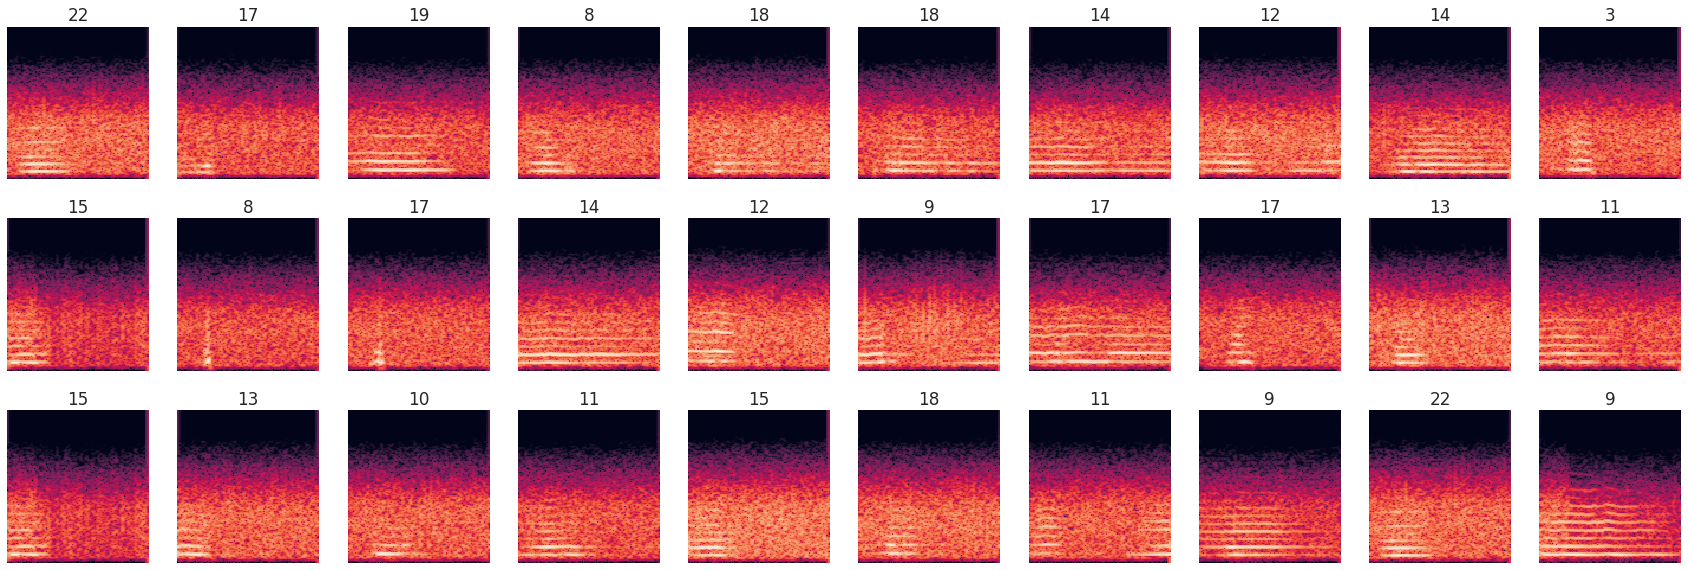

In [86]:
plt.figure(figsize=(30,10))
c=0
for i in range(50):
    plt.subplot(3,10,i+1)
    tmp_df = true_mel_pred_suz
    rdm = np.random.randint(0,tmp_df.shape[0])
    name = tmp_df.fnames.iloc[rdm]
    data = make_spectrogram(name=name)
    plt.imshow(data)#[:,:70])
    plt.gca().invert_yaxis()
    plt.title(tmp_df.hour.iloc[rdm])
    plt.axis('off')
    c+=1
    if c>29:
        break

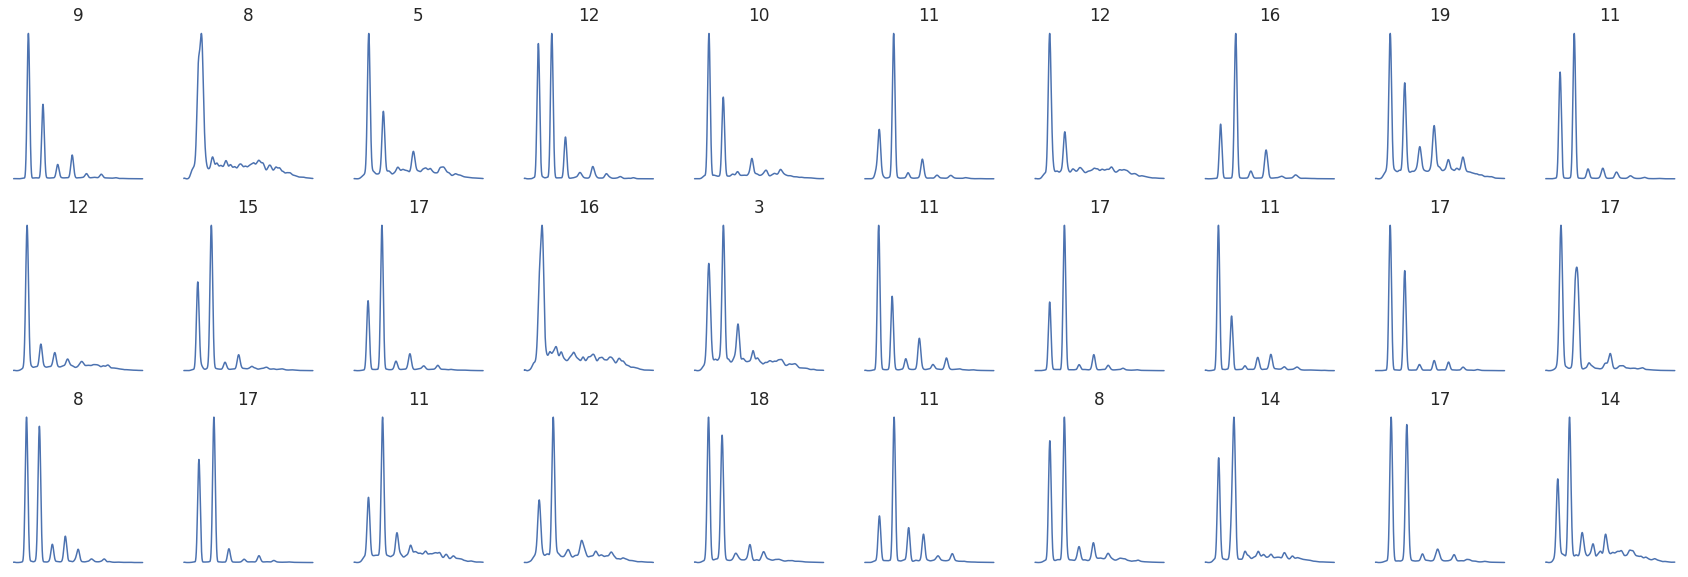

In [87]:
plt.figure(figsize=(30,10))
c=0
for i in range(50):
    plt.subplot(3,10,i+1)
    tmp_df = true_mel_pred_suz
    rdm = np.random.randint(0,tmp_df.shape[0])
    name = tmp_df.fnames.iloc[rdm]
    data = make_psd(name=name)
    plt.plot(data[:2000])
#     plt.gca().invert_yaxis()
    plt.title(tmp_df.hour.iloc[rdm])
    plt.axis('off')
    c+=1
    if c>29:
        break

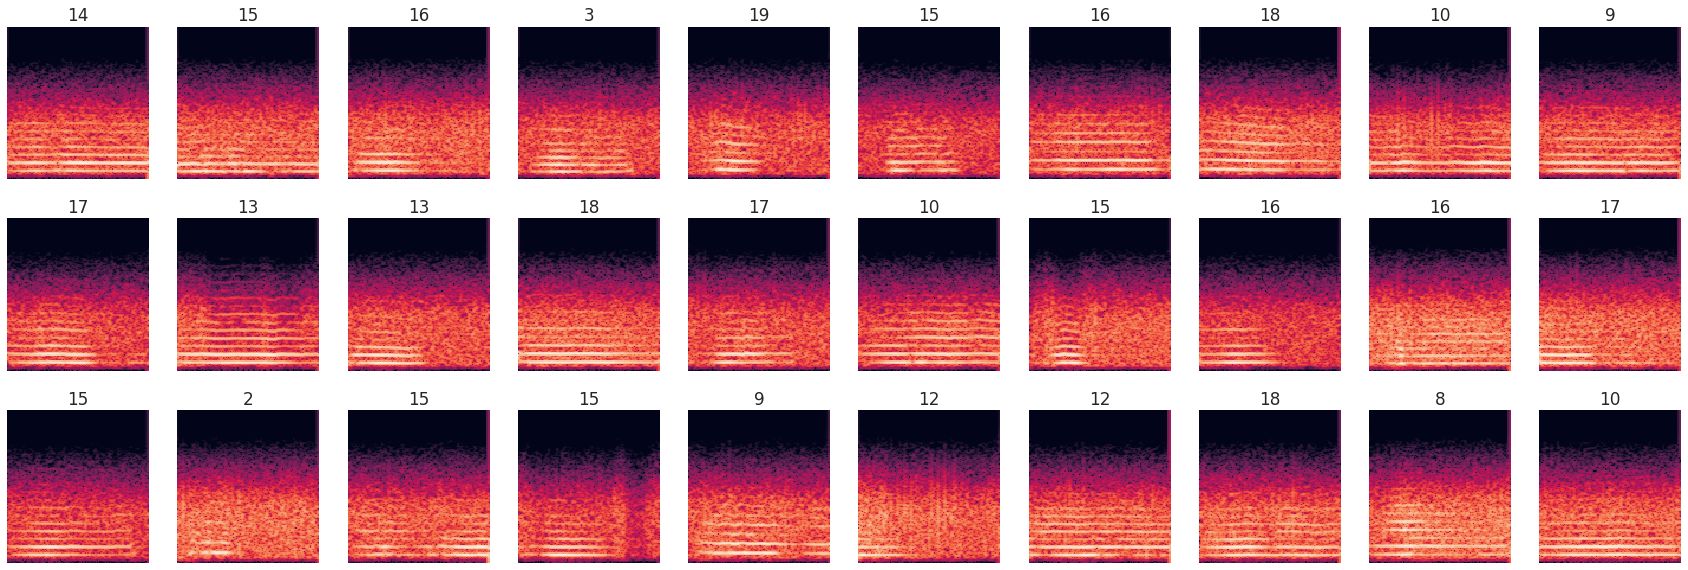

In [88]:
plt.figure(figsize=(30,10))
c=0
for i in range(50):
    plt.subplot(3,10,i+1)
    tmp_df = true_mel_pred_mel
    rdm = np.random.randint(0,tmp_df.shape[0])
    name = tmp_df.fnames.iloc[rdm]
    data = make_spectrogram(name=name)
    plt.imshow(data)#[:100,10:70])
    plt.gca().invert_yaxis()
    plt.title(tmp_df.hour.iloc[rdm])
    plt.axis('off')
    c+=1
    if c>29:
        break

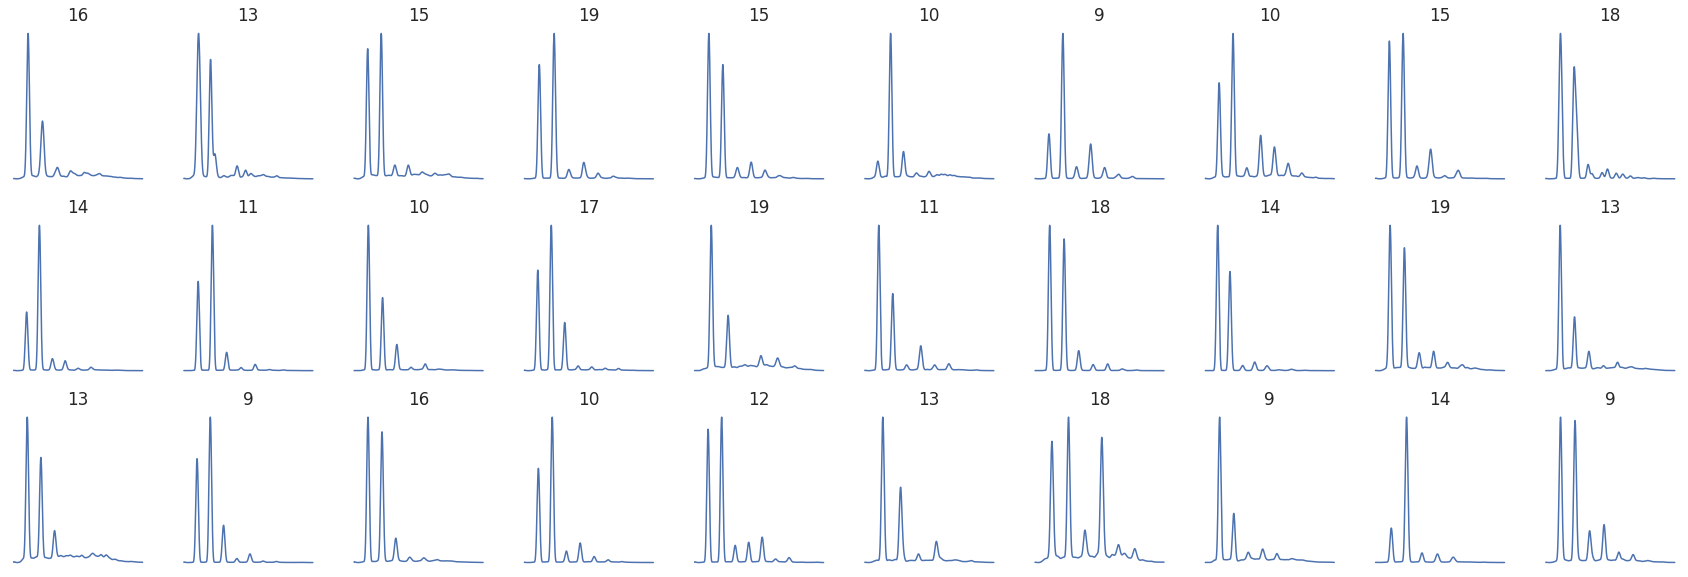

In [89]:
plt.figure(figsize=(30,10))
c=0
for i in range(50):
    plt.subplot(3,10,i+1)
    tmp_df = true_mel_pred_mel
    rdm = np.random.randint(0,tmp_df.shape[0])
    name = tmp_df.fnames.iloc[rdm]
    data = make_psd(name=name)
    plt.plot(data[:2000])
#     plt.gca().invert_yaxis()
    plt.title(tmp_df.hour.iloc[rdm])
    plt.axis('off')
    c+=1
    if c>29:
        break

In [90]:
def extract_features(fnames, labels, traincf):
    return model.predict(valid_generator(fnames, 
                                         labels,
                                         batch_size=traincf.batch_size,
                                         target_names=[0,1,2],
                                         setting=traincf.setting,
                                         preprocessing_train_stats=''),
                         steps=int(math.ceil(float(len(fnames))/float(traincf.batch_size))))

In [91]:
pd.DataFrame(pred).head()

0         1             2
0  0.000046  0.999951  2.654841e-06
1  0.024055  0.975772  1.725702e-04
2  0.000278  0.999718  4.032250e-06
3  0.000029  0.999970  6.266247e-07
4  0.003048  0.996950  1.737196e-06

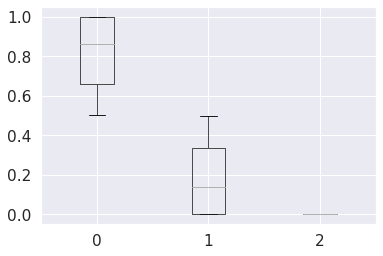

In [92]:
df = true_suz_pred_mel
pred_missed = extract_features(df.fnames.tolist(), df.labels.tolist(), traincf)
pd.DataFrame(np.round(pred_missed, decimals=4)).boxplot(showfliers=False)

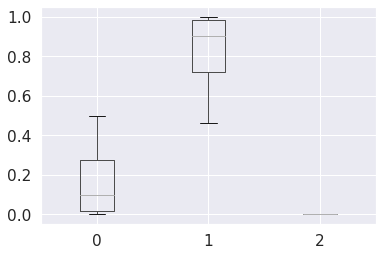

In [93]:
df = true_mel_pred_suz
pred_missed = extract_features(df.fnames.tolist(), df.labels.tolist(), traincf)
pd.DataFrame(np.round(pred_missed, decimals=4)).boxplot(showfliers=False)

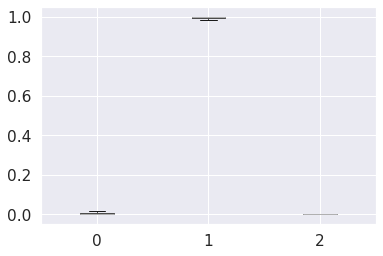

In [94]:
df = true_suz_pred_suz
pred_missed = extract_features(df.fnames.tolist(), df.labels.tolist(), traincf)
pd.DataFrame(np.round(pred_missed, decimals=4)).boxplot(showfliers=False)

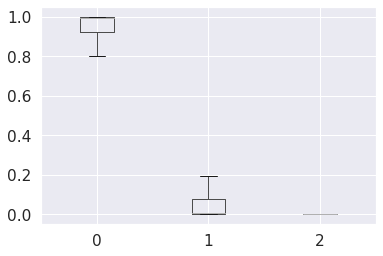

In [95]:
df = true_mel_pred_mel
pred_missed = extract_features(df.fnames.tolist(), df.labels.tolist(), traincf)
pd.DataFrame(np.round(pred_missed, decimals=4)).boxplot(showfliers=False)

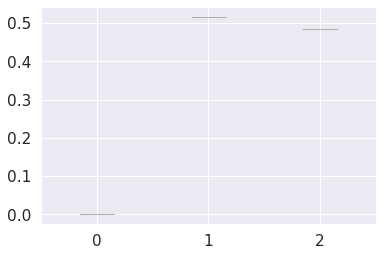

In [96]:
df = true_zap_pred_suz
pred_missed = extract_features(df.fnames.tolist(), df.labels.tolist(), traincf)
pd.DataFrame(np.round(pred_missed, decimals=4)).boxplot(showfliers=False)

# #

## TRUE: melanogaster - PREDICTED: suzukii

In [97]:
savesub = f'{TEMP_DATADIR}/missclassifications_TLTrue_rawflt_conv1d_random.csv'
df_TLraw = pd.read_csv(savesub)
savesub = f'{TEMP_DATADIR}/missclassifications_TLFalse_rawflt_conv1d_custom.csv'
df_raw = pd.read_csv(savesub)

savesub = f'{TEMP_DATADIR}/missclassifications_TLTrue_stftflt_DenseNet121_random.csv'
df_TLstft = pd.read_csv(savesub)
savesub = f'{TEMP_DATADIR}/missclassifications_TLFalse_stftflt_DenseNet121_custom.csv'
df_stft = pd.read_csv(savesub)

In [98]:
shared = len(set(df_raw.fnames.tolist()) & set(df_TLraw.fnames.tolist()))
print(f"raw: {df_raw.shape[0]} + rawTL: {df_TLraw.shape[0]}\nsharing: {shared}")
print(f"{shared / (df_raw.shape[0]+ df_TLraw.shape[0])*100:.2f}% shared")

raw: 249 + rawTL: 229
sharing: 168
35.15% shared


In [99]:
shared = len(set(df_stft.fnames.tolist()) & set(df_TLstft.fnames.tolist()))
print(f"stft: {df_stft.shape[0]} + stftTL: {df_TLstft.shape[0]}\nsharing: {shared}")
print(f"{shared / (df_stft.shape[0]+ df_TLstft.shape[0])*100:.2f}% shared")

stft: 404 + stftTL: 513
sharing: 334
36.42% shared


In [100]:
shared = len(set(df_stft.fnames.tolist()) & set(df_TLstft.fnames.tolist()) & set(df_raw.fnames.tolist()) & set(df_TLraw.fnames.tolist()))
print(f"shared among all: {shared}")

shared among all: 126


In [101]:
shared_all = list(set(df_stft.fnames.tolist()) & set(df_TLstft.fnames.tolist()) & set(df_raw.fnames.tolist()) & set(df_TLraw.fnames.tolist()))

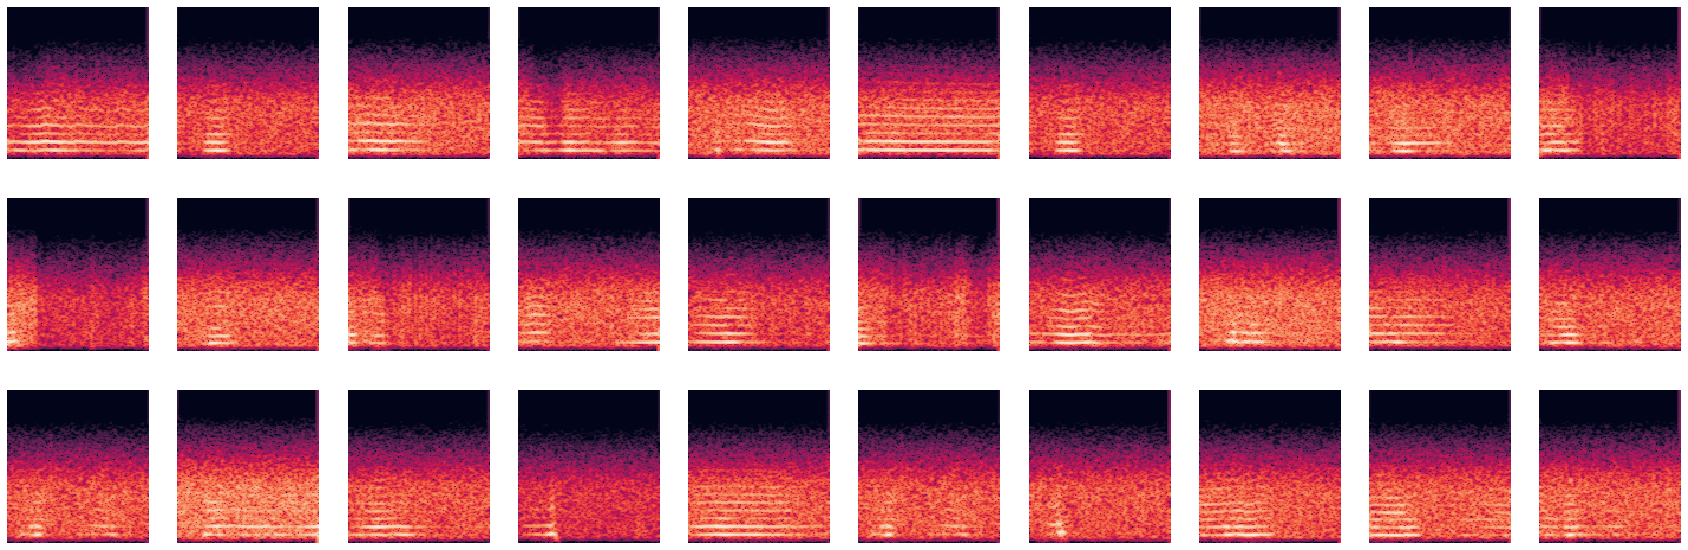

In [102]:
plt.figure(figsize=(30,10))
c=0
for i in range(50):
    plt.subplot(3,10,i+1)
    rdm = np.random.randint(0,len(shared_all))
    name = shared_all[rdm]
    data = make_spectrogram(name=name)
    plt.imshow(data)#[:100,10:70])
    plt.gca().invert_yaxis()
    plt.axis('off')
    c+=1
    if c>29:
        break

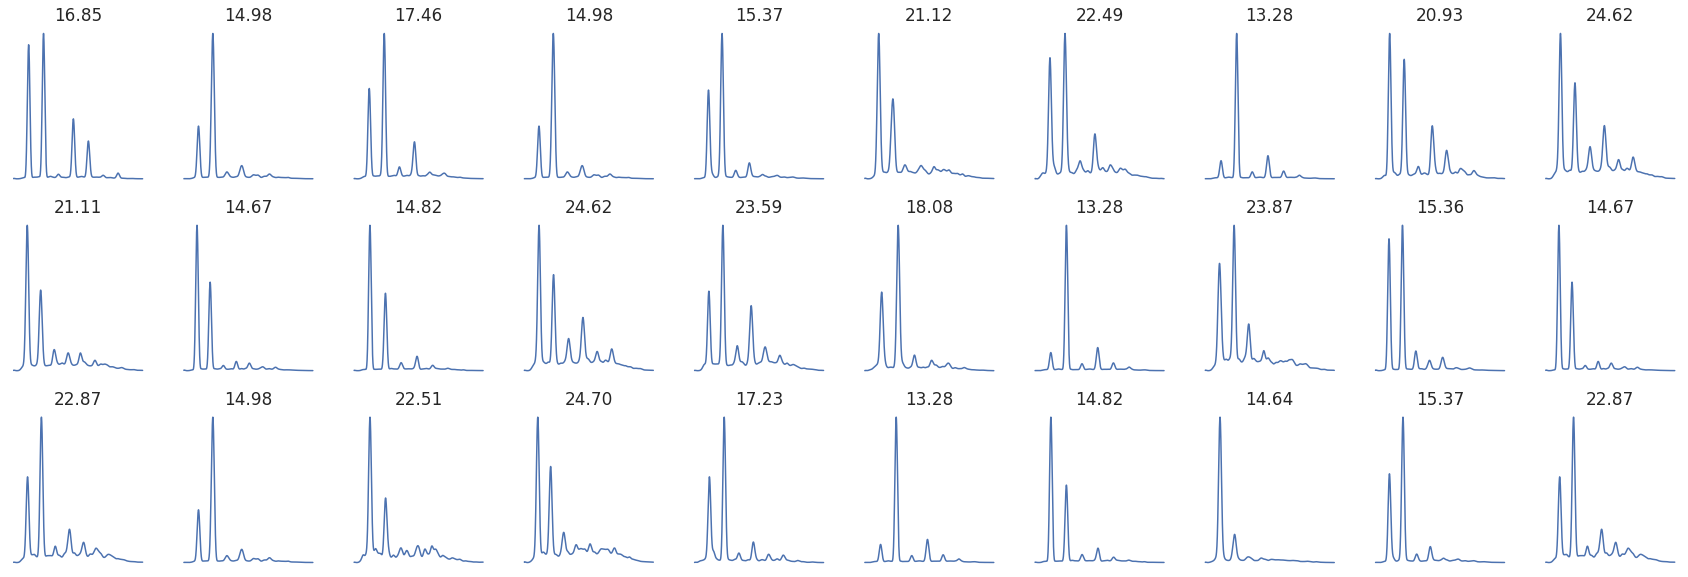

In [103]:
plt.figure(figsize=(30,10))
c=0
for i in range(50):
    plt.subplot(3,10,i+1)
    rdm = np.random.randint(0,len(shared_all))
    name = shared_all[rdm]
    data = make_psd(name=name)
    plt.plot(data[:2000])
    plt.title(f"{np.sum(data):.2f}")
    plt.axis('off')
    c+=1
    if c>29:
        break

In [105]:
shared = len(set(df_TLraw.fnames.tolist()) & set(df_TLstft.fnames.tolist()))
print(f"rawTL: {df_TLraw.shape[0]} + stftTL: {df_TLstft.shape[0]}\nsharing: {shared}")
print(f"{shared / (df_TLraw.shape[0]+ df_TLstft.shape[0])*100:.2f}% shared")

rawTL: 229 + stftTL: 513
sharing: 173
23.32% shared
